### Import Libraries

In [ ]:
import cv2
import numpy as np
import pandas as pd

In [ ]:
def generate_second_point(rvec, tvec, axis=0 ,axis_distance=0.01):
    # Convert rvec to rotation matrix
    rot_mat, _ = cv2.Rodrigues(rvec)
    
    # Extract the x-axis from the rotation matrix
    x_axis = rot_mat[ :,axis]
    
    # Scale the x-axis by the desired distance and add it to the origin
    second_point = tvec + x_axis * axis_distance
    
    return second_point

In [ ]:
def intersect_pnt(P11,P12,P21,P22):
  # Input values
  x1 = P11[0]
  x2 = P21[0]
  y1 = P11[1]
  y2 = P21[1]
  z1 = P11[2]
  z2 = P21[2]
  # direction vectors
  l1 = P12[0]-P11[0]
  m1 = P12[1]-P11[1]
  n1 = P12[2]-P11[2]

  l2 = P22[0]-P21[0]
  m2 = P22[1]-P21[1]
  n2 = P22[2]-P21[2]

  # Define the coefficient matrix and the constant vector
  A = np.array([[l1, -l2],
                [m1, -m2],
                [n1, -n2]])
  B = np.array([x2- x1, y2- y1, z2 - z1]).reshape(3,1)
  # Solve for t and s
  try:
    solution = np.linalg.pinv(A) @ B
    #print(solution)
    # Extract the values of t and s
    t = solution[0]
    s = solution[1]

    # Print the solution
    #print("The solution for t is: {}".format(t))
    #print("The solution for s is: {}".format(s))

    L1 = np.array([x1+l1*t, y1+m1*t, z1+n1*t])
    L2 = np.array([x2+l2*s, y2+m2*s, z2+n2*s])
    #print("intersection:", L1)

    if L2 == L1:
    #  print("Lines intersect")
      return L1
    else: return None
  except :
    print("error")


## 2 Markers Intersection

In [ ]:
import cv2
import numpy as np
import pandas as pd

inputVideo = cv2.VideoCapture("WIN_20230522_14_34_29_Pro_Trim.mp4")
if inputVideo.isOpened():
    ret, frame = inputVideo.read()

print(inputVideo.isOpened())

cameraMatrix = None
distCoeffs = None
markerLength = 0.0365

fs = cv2.FileStorage("tutorial_camera_params.yml", cv2.FILE_STORAGE_READ)
cameraMatrix = fs.getNode("cameraMatrix").mat()
distCoeffs = fs.getNode("distCoeffs").mat()
fs.release()

detectorParams = cv2.aruco.DetectorParameters()
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)

intersection_data = pd.DataFrame(columns=['Time', 'Marker ID', 'tx', 'ty', 'tz', 'rx', 'ry', 'rz'])

prev_positions = {}
frame_count = 0
fps = inputVideo.get(cv2.CAP_PROP_FPS)
while True:
    ret, frame = inputVideo.read()
    if not ret:
        break
    height, width = frame.shape[:2]
    print("size: ", frame.shape[:2])
    scale = 1
    scaled_frame = cv2.resize(frame, (int(width*scale), int(height*scale)))
    image = cv2.cvtColor(scaled_frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(image, dictionary, parameters=detectorParams)
    if ids is not None and len(ids) > 0:
        cv2.aruco.drawDetectedMarkers(scaled_frame, corners, ids)
        rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(corners, markerLength, cameraMatrix, distCoeffs)
        
        detected_ids = set(ids.flatten())
        if 5 in detected_ids and 13 in detected_ids:  # check for required ids
            marker_1_index = np.where(ids == 5)[0][0]
            marker_2_index = np.where(ids == 13)[0][0]
            marker_1 = tvecs[marker_1_index]
            marker_2 = tvecs[marker_2_index]
            
            print("marker1", marker_1, "marker2", marker_2)

            # find the intersection point
            marker_1_x = marker_1[0][0]
            marker_2_x = marker_2[0][0]
            
            point0 = marker_1.flatten()
            point1 = generate_second_point(rvecs[marker_1_index], tvecs[marker_1_index], axis=0).flatten()

            point2 = marker_2.flatten()
            point3 = generate_second_point(rvecs[marker_2_index], tvecs[marker_2_index], axis= 1).flatten()

            rvec = np.zeros((3, 1))
            tvec = np.zeros((3, 1))
            point1_px = cv2.projectPoints(tvecs[marker_1_index], rvec, tvec, cameraMatrix, distCoeffs)[0][0]
            point2_px = cv2.projectPoints(tvecs[marker_2_index], rvec, tvec, cameraMatrix, distCoeffs)[0][0]
            #cv2.circle(scaled_frame, (int(point1_px[0]), int(point1_px[1])), 5, (0, 0, 255), -1)

            print("point1_px", point1_px)
        
            print('point0: ', point0)
            print('point1: ', point1)
            print('point2: ', point2)
            print('point3: ', point3)
           
            intersection = intersect_pnt(point0, point1, point2, point3)

            # Draw circles at the intersection and second points
            cv2.circle(scaled_frame, (int(point1[0]), int(point1[1])), 5, (0, 255, 0), -1)
            cv2.circle(scaled_frame, (int(point3[0]), int(point3[1])), 5, (0, 0, 255), -1)

            print("intersection: ", intersection)
            print('tvecs[marker_1_index]',tvecs[marker_1_index])
            print('rvecs[marker_1_index]',rvecs[marker_1_index])

            # Check if the intersection point is valid
            if intersection is not None:
                # Calculate the timer value
                timer = frame_count / fps

                # Save the intersection point data
                data = {
                    'Time': timer,
                    'tx': intersection[0],
                    'ty': intersection[1],
                    'tz': intersection[2],
                    'rx': rvecs[marker_1_index][0][0],
                    'ry': rvecs[marker_1_index][0][1],
                    'rz': rvecs[marker_1_index][0][2]
                }
                intersection_data = intersection_data.append(data, ignore_index=True)
                image_points = cv2.projectPoints(intersection, rvecs[marker_1_index][0], tvecs[marker_1_index][0], cameraMatrix, distCoeffs)[0][0]
                

                # Draw a circle at the intersection point
                print("image_points", image_points)
                cv2.circle(scaled_frame, (int(image_points[0][0]), int(image_points[0][1])), 5, (255, 0, 255), -1)
            
        # Draw the detected aruco markers and axes
        ee = cv2.aruco.drawDetectedMarkers(scaled_frame, corners, ids)
        for i in range(len(ids)):
            ee = cv2.drawFrameAxes(ee, cameraMatrix, distCoeffs, rvecs[i], tvecs[i], 0.1, thickness=2)
        
    # Display the resulting frame
    cv2.imshow('frame', ee)

    frame_count += 1

    # Exit loop if 'esc' key is pressed
    key = cv2.waitKey(1)
    if key == 27:
        break

# Release the video capture object and close all windows
intersection_data.to_csv('intersection_data.csv', index=False)

inputVideo.release()
cv2.destroyAllWindows()

In [ ]:
rvecs[marker_1_index][0][0]

## Add Base Marker

In [634]:
import cv2
import numpy as np
import pandas as pd

inputVideo = cv2.VideoCapture("14_37.mp4")

if inputVideo.isOpened():
    ret, frame = inputVideo.read()

print(inputVideo.isOpened())

cameraMatrix = None
distCoeffs = None
markerLength = 0.0365
frame_count = 0
fs = cv2.FileStorage("tutorial_camera_params.yml", cv2.FILE_STORAGE_READ)
cameraMatrix = fs.getNode("cameraMatrix").mat()
distCoeffs = fs.getNode("distCoeffs").mat()
fs.release()

#objPoints = np.array([[-markerLength/2.0, markerLength/2.0, 0], [markerLength/2.0, markerLength/2.0, 0], [markerLength/2.0, -markerLength/2.0, 0], [-markerLength/2.0, -markerLength/2.0, 0]], dtype=np.float32)

detectorParams = cv2.aruco.DetectorParameters()
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)

intersection_data = pd.DataFrame(columns=['Time', 'tx', 'ty', 'tz', 'rx', 'ry', 'rz'])
base_marker_id = 11  # ID of the additional marker at the base
base_tvec = np.zeros((3, 1))
base_rvec = np.zeros((3, 1))

fps = inputVideo.get(cv2.CAP_PROP_FPS)

# Define the camera's position and orientation relative to the world coordinate system
R_cam = np.eye(3)  # Identity matrix if the camera is already in the world coordinate system
T_cam = np.zeros((3, 1))  # Translation vector of the camera in the world coordinate system


# Define the output video file name and parameters
output_file = 'output_video.mp4'
output_fps = inputVideo.get(cv2.CAP_PROP_FPS)
output_width = int(inputVideo.get(cv2.CAP_PROP_FRAME_WIDTH) * scale)
output_height = int(inputVideo.get(cv2.CAP_PROP_FRAME_HEIGHT) * scale)

# Create the video writer object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_file, fourcc, output_fps, (output_width, output_height))

while True:
    ret, frame = inputVideo.read()
    if not ret:
        break
    height, width = frame.shape[:2]
    scale = 0.7
    scaled_frame = cv2.resize(frame, (int(width*scale), int(height*scale)))
    image = cv2.cvtColor(scaled_frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(image, dictionary, parameters=detectorParams)
    if ids is not None and len(ids) > 0:
        cv2.aruco.drawDetectedMarkers(scaled_frame, corners, ids)
        rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(corners, markerLength, cameraMatrix, distCoeffs)
        for id, rvec, tvec in zip(ids, rvecs, tvecs):
            cv2.drawFrameAxes(scaled_frame, cameraMatrix, distCoeffs, rvec, tvec, 0.1, 2)
            
            detected_ids = set(ids.flatten())

            if 8 in detected_ids and 14 in detected_ids and 7 in detected_ids and 11 in detected_ids:  # check for required ids 
                    marker_base_index = np.where(ids == 11)[0][0]
                    marker_1_index = np.where(ids == 8)[0][0]
                    marker_2_index = np.where(ids == 14)[0][0]
                    marker_3_index = np.where(ids == 7)[0][0]
                    
                    marker_base_t = tvecs[marker_base_index]
                    marker_base_r = rvecs[marker_base_index]

                    marker_1 = tvecs[marker_1_index]
                    marker_2 = tvecs[marker_2_index]
                    marker_3 = tvecs[marker_3_index]
                    
                    marker_1_rvec = rvecs[marker_1_index]
                    marker_2_rvec = rvecs[marker_2_index]
                    marker_3_rvec = rvecs[marker_3_index]

                    intersection = np.mean([marker_1,marker_2,marker_3], axis=0)
                    rvec_intersect = np.mean([marker_1_rvec,marker_2_rvec,marker_3_rvec], axis=0)
                    print(rvec_intersect)

                    rvec = np.zeros((3,1))
                    tvec = np.zeros((3,1))
                    imgpts, _ = cv2.projectPoints(intersection, rvec, tvec, cameraMatrix, distCoeffs)
                    
                    # draw circle at intersection point
                    center = tuple(map(int, imgpts[0].ravel()))
                    cv2.circle(scaled_frame, center, 3, (255, 255, 0), -1)
                    
                    if id == base_marker_id:
                        base_tvec = tvec
                        base_rvec = rvec
                        continue

                    # Check if the intersection point is valid
                    if intersection is not None:
                        # Calculate the timer value
                        frame_count += 1 / fps

                        # Save the intersection point data
                        data = {
                            'Time': frame_count,
                            'tx': intersection[0][0],
                            'ty': intersection[0][1],
                            'tz': intersection[0][2],
                            'rx': marker_1_rvec[0][0],
                            'ry': marker_1_rvec[0][1],
                            'rz': marker_1_rvec[0][2]
                        }
                        intersection_data = intersection_data.append(data, ignore_index=True)
                        
                        cv2.circle(scaled_frame, center, 3, (255, 255, 0), -1)
    # Display the resulting frame
    cv2.imshow('frame', scaled_frame)

    # Write the frame to the output video file
    video_writer.write(scaled_frame)
    cv2.imshow("out", scaled_frame)
    key = cv2.waitKey(1)
    if key == 27:
        break

intersection_data.to_csv('nontransformed.csv', index=False)
inputVideo.release()
video_writer.release()

cv2.destroyAllWindows()

True
[[-1.36783063 -0.63544189  0.19968591]]
[[-1.36783063 -0.63544189  0.19968591]]
[[-1.36783063 -0.63544189  0.19968591]]
[[-1.36783063 -0.63544189  0.19968591]]
[[1.30601698 2.27899924 0.20636293]]
[[1.30601698 2.27899924 0.20636293]]
[[1.30601698 2.27899924 0.20636293]]
[[1.30601698 2.27899924 0.20636293]]
[[-1.35943084 -0.62859408  0.20704091]]
[[-1.35943084 -0.62859408  0.20704091]]
[[-1.35943084 -0.62859408  0.20704091]]
[[-1.35943084 -0.62859408  0.20704091]]
[[0.38751487 0.51066548 0.08772337]]
[[0.38751487 0.51066548 0.08772337]]
[[0.38751487 0.51066548 0.08772337]]
[[0.38751487 0.51066548 0.08772337]]
[[0.38568276 0.47277371 0.17965974]]
[[0.38568276 0.47277371 0.17965974]]
[[0.38568276 0.47277371 0.17965974]]
[[0.38568276 0.47277371 0.17965974]]
[[-0.47526928  1.11440589  0.25221342]]
[[-0.47526928  1.11440589  0.25221342]]
[[-0.47526928  1.11440589  0.25221342]]
[[-0.47526928  1.11440589  0.25221342]]
[[-0.46397279  1.1004524   0.22855398]]
[[-0.46397279  1.1004524   0.22

In [420]:
marker_1_rvec[0]

array([-0.04103559,  2.88987011,  0.32405552])

In [421]:
import pandas as pd

# Read the CSV file
data = pd.read_csv('nontransformed.csv')

# Write the data to a TXT file
data.to_csv('nontransformed.txt', index=False, sep='\t', header=None)

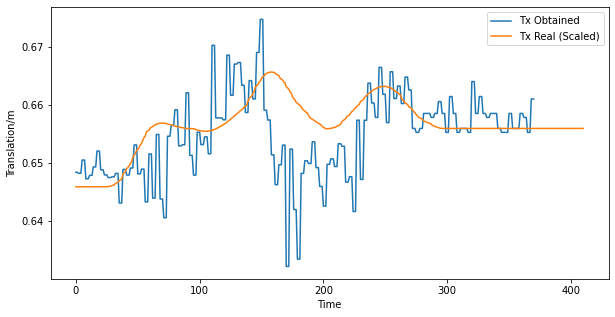

In [710]:
import matplotlib.pyplot as plt
import numpy as np

# Load data from the first file (real results)
real_results = np.loadtxt('iiwa_ee2.txt', usecols=(0, 1, 2, 3, 4, 5))

# Read the CSV file using pandas
data = pd.read_csv('nontransformed.csv')

# Extract the timestamp column
obtained_tx = data['tz'].values

# Extract translation data
real_tx = real_results[:, 0]

# Compute the scaling factor
scaling_factor = len(obtained_tx) / len(real_tx)

# Scale the larger dataset to match the length of the smaller dataset
scaled_real_tx = np.interp(np.arange(len(obtained_tx)), np.arange(len(real_tx)) * scaling_factor, real_tx)

# Make the obtained data the opposite
obtained_tx_opposite = -obtained_tx + 1.621

# Slice the obtained data from the 100th row onwards
obtained_tx_opposite = obtained_tx_opposite[40:]

# Create subplots for translation
fig, ax = plt.subplots(figsize=(10, 5))

# Plot translation
ax.plot(obtained_tx_opposite, label='Tx Obtained')
ax.plot(scaled_real_tx, label='Tx Real (Scaled)')

# Set labels and legend for translation plot
ax.set_xlabel('Time')
ax.set_ylabel('Translation/m')
ax.legend()

# Save the plot as a PDF
plt.savefig('tx_plot.pdf')

# Show the plot
plt.show()

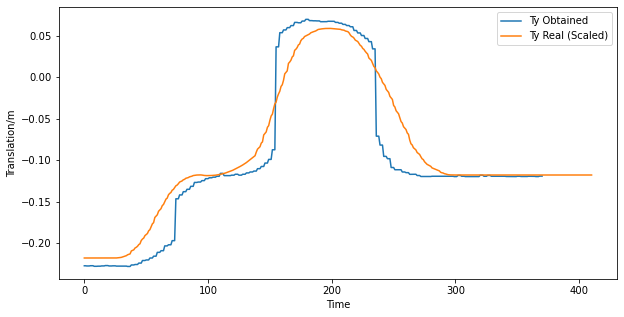

In [709]:
import matplotlib.pyplot as plt
import numpy as np

# Load data from the first file (real results)
real_results = np.loadtxt('iiwa_ee2.txt', usecols=(0, 1, 2, 3, 4, 5))

# Read the CSV file using pandas
data = pd.read_csv('nontransformed.csv')

# Extract the timestamp column
obtained_ty = data['tx'].values

# Extract translation data
real_ty = real_results[:, 1]

# Compute the scaling factor
scaling_factor = len(obtained_ty) / len(real_ty)

# Scale the larger dataset to match the length of the smaller dataset
scaled_real_ty = np.interp(np.arange(len(obtained_ty)), np.arange(len(real_ty)) * scaling_factor, real_ty)
scaled_real_ty = scaled_real_ty[:]

# Make the obtained data the opposite
obtained_ty_opposite = obtained_ty + 0.024
# Slice the obtained data from the 100th row onwards
obtained_ty_opposite = obtained_ty_opposite[40:]


#max_yerror = np.average(np.abs(obtained_ty_opposite - scaled_real_ty))
#print("Max ty error:",max_yerror)
# Create subplots for translation
fig, ax = plt.subplots(figsize=(10, 5))

# Plot translation
ax.plot(obtained_ty_opposite, label='Ty Obtained')
ax.plot(scaled_real_ty, label='Ty Real (Scaled)')

# Set labels and legend for translation plot
ax.set_xlabel('Time')
ax.set_ylabel('Translation/m')
ax.legend()

# Save the plot as a PDF
#plt.savefig('ty_plot.pdf')
# Show the plot
plt.show()

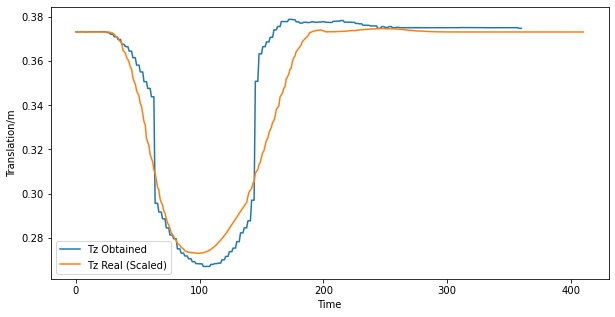

In [708]:
import matplotlib.pyplot as plt
import numpy as np

# Load data from the first file (real results)
real_results = np.loadtxt('iiwa_ee2.txt', usecols=(0, 1, 2, 3, 4, 5))

# Read the CSV file using pandas
data = pd.read_csv('nontransformed.csv')

# Extract the timestamp column
obtained_tz = data['ty'].values

# Extract translation data
real_tz = real_results[:, 2]

# Compute the scaling factor
scaling_factor = len(obtained_tz) / len(real_tz)

# Scale the larger dataset to match the length of the smaller dataset
scaled_real_tz = np.interp(np.arange(len(obtained_tz)), np.arange(len(real_tz)) * scaling_factor, real_tz)

# Make the obtained data the opposite
obtained_tz_opposite = -obtained_tz + 0.32
# Slice the obtained data from the 100th row onwards
obtained_tz_opposite = obtained_tz_opposite[50:]

# Create subplots for translation
fig, ax = plt.subplots(figsize=(10, 5))

# Plot translation
ax.plot(obtained_tz_opposite, label='Tz Obtained')
ax.plot(scaled_real_tz, label='Tz Real (Scaled)')

# Set labels and legend for translation plot
ax.set_xlabel('Time')
ax.set_ylabel('Translation/m')
ax.legend()

# Save the plot as a PDF
plt.savefig('tz_plot.pdf')

# Show the plot
plt.show()

## Orientation

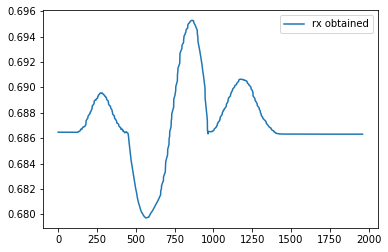

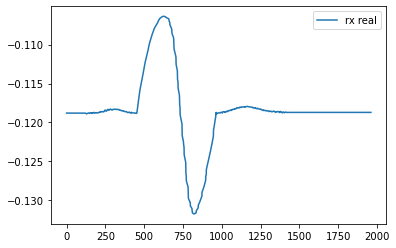

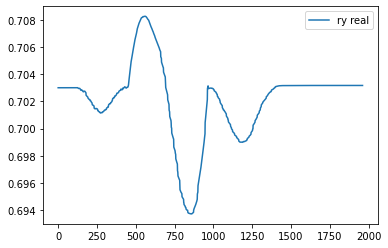

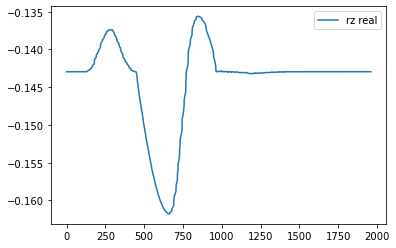

In [572]:
real_results = np.loadtxt('iiwa_ee2.txt', usecols=(0, 1, 2, 3, 4, 5, 6))

# Read the CSV file using pandas
data = pd.read_csv('nontransformed.csv')

# Extract the timestamp column
obtained_rx = data['rx'].values
obtained_ry = data['ry'].values
obtained_rz = data['rz'].values

# Extract translation data
real_rx = real_results[:, 3]
real_ry = real_results[:, 4]
real_rz = real_results[:, 5]
real_rw = real_results[:, 6]

plt.figure(1)
plt.plot(real_rw, label="rx obtained")
plt.legend()

plt.figure(2)
plt.plot(real_rx, label="rx real")
plt.legend()

plt.figure(3)
plt.plot(real_ry, label="ry real")
plt.legend()

plt.figure(4)
plt.plot(real_rz, label="rz real")
plt.legend()

plt.show()

In [575]:
import math
import numpy as np

def euler_from_quaternion(quaternion):
    """
    Convert a quaternion into euler angles (roll, pitch, yaw)
    roll is rotation around x in radians (counterclockwise)
    pitch is rotation around y in radians (counterclockwise)
    yaw is rotation around z in radians (counterclockwise)
    """
    x, y, z, w = quaternion[:, 0], quaternion[:, 1], quaternion[:, 2], quaternion[:, 3]

    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll_x = np.arctan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = np.clip(t2, -1.0, 1.0)  # Ensure t2 stays within [-1, 1] due to floating-point precision
    pitch_y = np.arcsin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw_z = np.arctan2(t3, t4)

    return roll_x, pitch_y, yaw_z  # in radians

# Call the modified euler_from_quaternion function
roll, pitch, yaw = euler_from_quaternion(np.column_stack((real_rx, real_ry, real_rz, real_rw)))

# Print the results
for r, p, y in zip(roll, pitch, yaw):
    print(f"Roll: {r}, Pitch: {p}, Yaw: {y}")

# Create a DataFrame to store the results
results = pd.DataFrame({'Roll': roll, 'Pitch': pitch, 'Yaw': yaw})

# Save the DataFrame to a CSV file
results.to_csv('rpy_results.csv', index=False)

Roll: -1.61647001400541, Pitch: 1.1977274342406465, Yaw: -1.6512351403327794
Roll: -1.61647001400541, Pitch: 1.1977274342406465, Yaw: -1.6512351403327794
Roll: -1.61647001400541, Pitch: 1.1977274342406465, Yaw: -1.6512351403327794
Roll: -1.61647001400541, Pitch: 1.1977274342406465, Yaw: -1.6512351403327794
Roll: -1.6164688835830003, Pitch: 1.1977282186739708, Yaw: -1.6512354503002824
Roll: -1.61647001400541, Pitch: 1.1977274342406465, Yaw: -1.6512351403327794
Roll: -1.6164688835830003, Pitch: 1.1977282186739708, Yaw: -1.6512354503002824
Roll: -1.61647001400541, Pitch: 1.1977274342406465, Yaw: -1.6512351403327794
Roll: -1.6164688835830003, Pitch: 1.1977282186739708, Yaw: -1.6512354503002824
Roll: -1.61647001400541, Pitch: 1.1977274342406465, Yaw: -1.6512351403327794
Roll: -1.61647001400541, Pitch: 1.1977274342406465, Yaw: -1.6512351403327794
Roll: -1.6164688835830003, Pitch: 1.1977282186739708, Yaw: -1.6512354503002824
Roll: -1.6164688835830003, Pitch: 1.1977282186739708, Yaw: -1.651235

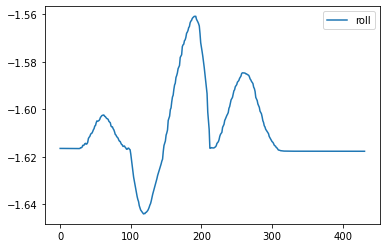

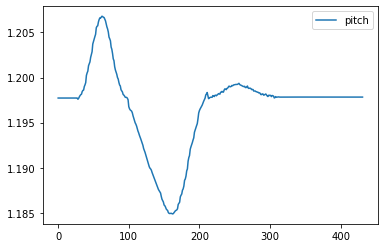

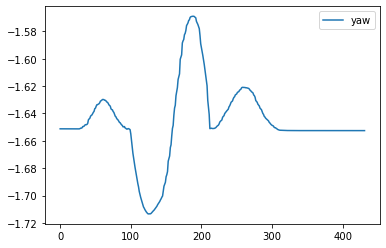

In [614]:
real_results = pd.read_csv('rpy_results.csv')

# Read the CSV file using pandas
data = pd.read_csv('nontransformed.csv')

# Extract the column
obtained_rx = data['rx'].values
obtained_ry = data['ry'].values
obtained_rz = data['rz'].values

# Extract the column
roll = real_results['Roll'].values
pitch = real_results['Pitch'].values
yaw = real_results['Yaw'].values

# Compute the scaling factor
scaling_factor = len(obtained_rx) / len(roll)

# Scale the larger dataset to match the length of the smaller dataset
scaled_roll = np.interp(np.arange(len(obtained_rx)), np.arange(len(roll)) * scaling_factor, roll)
scaled_pitch = np.interp(np.arange(len(obtained_ry)), np.arange(len(pitch)) * scaling_factor, pitch)
scaled_yaw = np.interp(np.arange(len(obtained_rz)), np.arange(len(yaw)) * scaling_factor, yaw)

obtained_rx = obtained_rx -1.5
obtained_ry = obtained_ry - 2
obtained_rz = obtained_rz -1
plt.figure(1)
plt.plot(scaled_roll, label="roll")
#plt.plot(obtained_rx, label='obtained_rx')
plt.legend()

plt.figure(2)
plt.plot(scaled_pitch, label="pitch")
#plt.plot(obtained_ry, label='obtained_ry')
plt.legend()

plt.figure(3)
plt.plot(scaled_yaw, label="yaw")
#plt.plot(obtained_rz, label='obtained_rz')
plt.legend()

plt.show()

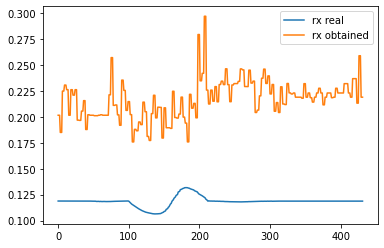

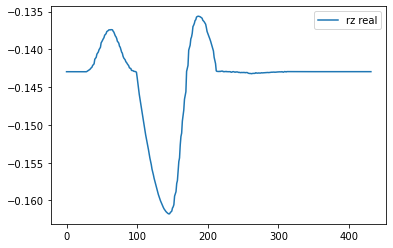

In [506]:
real_results = np.loadtxt('iiwa_ee2.txt', usecols=(0, 1, 2, 3, 4, 5))

# Read the CSV file using pandas
data = pd.read_csv('nontransformed.csv')

# Extract the timestamp column
obtained_rx = data['rx'].values
obtained_ry = data['ry'].values
obtained_rz = data['rz'].values


# Extract translation data
real_rx = real_results[:, 3]
real_ry = real_results[:, 4]
real_rz = real_results[:, 5]

# Compute the scaling factor
scaling_factorx = len(obtained_rx) / len(real_rx)
scaling_factory = len(obtained_ry) / len(real_ry)
scaling_factorz = len(obtained_rz) / len(real_rz)


# Scale the larger dataset to match the length of the smaller dataset
scaled_real_rx = np.interp(np.arange(len(obtained_rx)), np.arange(len(real_rx)) * scaling_factorx, real_rx)
scaled_real_ry = np.interp(np.arange(len(obtained_ry)), np.arange(len(real_ry)) * scaling_factory, real_ry)
scaled_real_rz = np.interp(np.arange(len(obtained_rz)), np.arange(len(real_rz)) * scaling_factorz, real_rz)


obtained_rx_opposite = obtained_rx + 0.26
obtained_ry_opposite = -obtained_ry + 0.8
obtained_rz_opposite = -obtained_rz + 0.56

plt.figure(1)
plt.plot(-scaled_real_rx, label="rx real")
plt.plot(obtained_rx_opposite, label="rx obtained")
plt.legend()

'''
plt.figure(2)
plt.plot(scaled_real_ry, label="ry real")
#plt.plot(obtained_ry_opposite, label="ry obtained")
plt.legend()
'''
plt.figure(3)
plt.plot(scaled_real_rz, label="rz real")
#plt.plot(obtained_rz_opposite, label="rz obtained")
plt.legend()

plt.show()

## Kalman Filter

In [36]:
!pip install filterpy


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [712]:
with open('nontransformed.txt', 'r') as infile:
    stripped = [line.strip() for line in infile.readlines()]
    lines = [line.split('\t') for line in stripped if line]
    gps1 = [[float(number) for number in line] for line in lines]

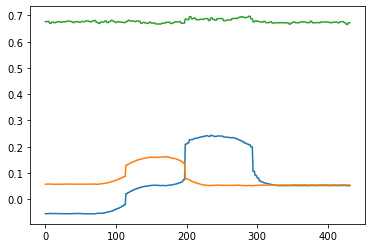

0.07975711805555612


In [713]:
gps1 = np.array(gps1)
gps = gps1[:,1:4]
plt.plot(gps)
plt.show()
time = gps1[:,0]
dT = time[1:] - time[:-1]
print(np.mean(dT))


In [714]:
threshold = 0.05

def remove_spikes(s):
    N = len(s)
    clean_s = []
    for i in range(3):
        diff = s[1][i] - s[0][i]
        if False:
            clean_s.append(s[0][i] + np.sign(diff)*threshold)
        else:
            clean_s.append(s[1][i])
    return np.array(clean_s)

In [715]:
data = gps.copy()

In [716]:
var_x = data[:, 0].var()
var_y = data[:,1].var()
var_z = data[:, 2].var()

In [717]:
from filterpy.kalman import KalmanFilter

f = KalmanFilter(dim_x=6, dim_z=3)

In [718]:
f.x = np.array([data[0][0], data[0][1],data[0][2], 0, 0,0])

dt = np.mean(dT)
f.F = np.array([[1., 0., 0., dt, 0., 0.],  # state transition matrix
                [0., 1., 0., 0., dt, 0.],
                [0., 0., 1., 0., 0., dt],
                [0., 0., 0., 1., 0., 0.],
                [0., 0., 0., 0., 1., 0.],
                [0., 0., 0., 0., 0., 1.]])

f.H = np.array([[1., 0., 0., 0., 0., 0.],
                [0., 1., 0., 0., 0., 0.],
                [0., 0., 1., 0., 0., 0.]])  # measurement function

f.P = np.eye(6)  # covariance matrix

f.R = np.array([[var_x, 0, 0],
                [0, var_y, 0],
                [0, 0, var_z]])  # measurement uncertainty/noise

f.Q = np.array([[dt**4/4*var_x, 0., 0., dt**3/2*var_x, 0., 0.],  # state transition matrix
                [0., dt**4/4*var_y, 0., 0., dt**3/2*var_y, 0.],
                [0., 0., dt**4/4*var_z, 0., 0., dt**3/2*var_z],
                [dt**3/2*var_x, 0., 0., dt**2*var_x, 0., 0.],
                [0., dt**3/2*var_y, 0., 0., dt**2*var_y, 0.],
                [0., 0., dt**3/2*var_z, 0., 0., dt**2*var_z]])

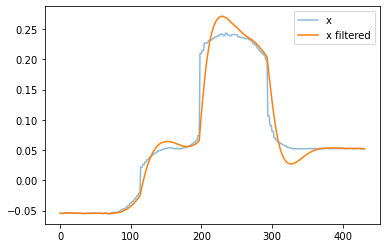

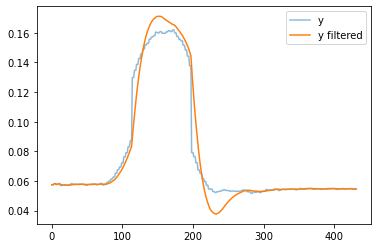

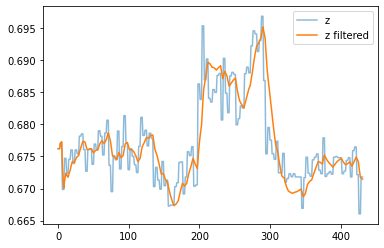

In [719]:
from time import perf_counter

x_est = []
x_est.append(f.x)

t0 = perf_counter()

for n in range(1, len(data)):
    f.predict()

    # x = remove_spikes(data[n-1:n+1, :3])
    # data[n, :3] = x
    f.update(np.array(data[n,:3]))
    x_est.append(f.x)

x_est = np.array(x_est)
plt.figure(1)
plt.plot(gps[:, 0],alpha=0.5,label="x")
plt.plot(x_est[:, 0],label="x filtered")
plt.legend()

plt.figure(2)
plt.plot(gps[:, 1],alpha=0.5,label="y")
plt.plot(x_est[:, 1],label="y filtered")
plt.legend()

plt.figure(3)
plt.plot(gps[:, 2],alpha=0.5,label="z")
plt.plot(x_est[:, 2],label="z filtered")
plt.legend()

plt.show()

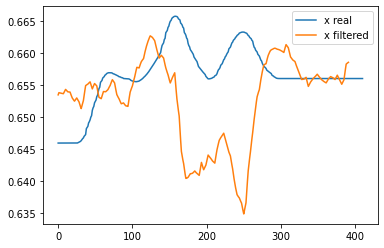

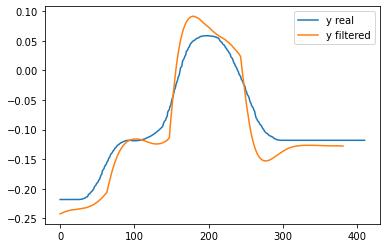

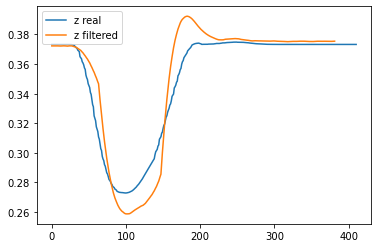

In [758]:
from time import perf_counter

x_est = []
x_est.append(f.x)

t0 = perf_counter()

for n in range(1, len(data)):
    f.predict()

    # x = remove_spikes(data[n-1:n+1, :3])
    # data[n, :3] = x
    f.update(np.array(data[n,:3]))
    x_est.append(f.x)

x_est = np.array(x_est)

plt.figure(1)
plt.plot(scaled_real_tx, label="x real")
plt.plot(-x_est[40:, 2] + 1.33, label="x filtered")
plt.legend()

plt.figure(2)
plt.plot(scaled_real_ty, label="y real")
plt.plot(x_est[50:, 0] - 0.18, label="y filtered")
plt.legend()

plt.figure(3)
plt.plot(scaled_real_tz, label="z real")
plt.plot(-x_est[50:, 1] + 0.43, label="z filtered")
plt.legend()


plt.show()

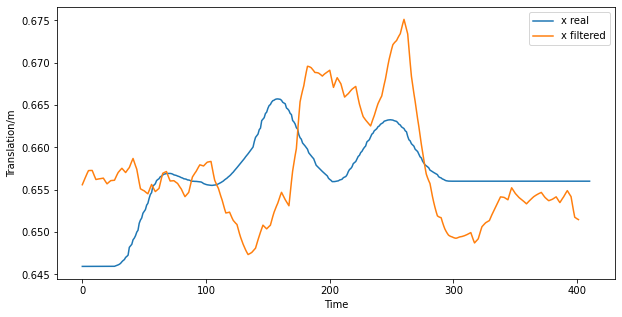

In [791]:
from time import perf_counter

x_est = []
x_est.append(f.x)

t0 = perf_counter()

for n in range(1, len(data)):
    f.predict()

    # x = remove_spikes(data[n-1:n+1, :3])
    # data[n, :3] = x
    f.update(np.array(data[n,:3]))
    x_est.append(f.x)

x_est = np.array(x_est)

# Create subplots for translation
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(scaled_real_tx, label="x real")
ax.plot(x_est[30:, 2] - 0.02, label="x filtered")


# Set labels and legend for translation plot
ax.set_xlabel('Time')
ax.set_ylabel('Translation/m')
ax.legend()

# Save the plot as a PDF
plt.savefig('tx_filtered.pdf')

# Show the plot
plt.show()

## Transformation Function

In [ ]:
import cv2
import numpy as np

def transform_to_robot_base(camera_pose, base_marker_pose):
    tvecs_cam, rvecs_cam = camera_pose
    tvecs_base_marker, rvecs_base_marker = base_marker_pose

    R_cam, _ = cv2.Rodrigues(rvecs_cam)
    R_base_marker, _ = cv2.Rodrigues(rvecs_base_marker)

    R_base_marker_inv = np.linalg.inv(R_base_marker)
    tvecs_base_marker_inv = -R_base_marker_inv @ tvecs_base_marker

    R_base = R_cam @ R_base_marker_inv
    tvecs_base = R_cam @ tvecs_base_marker + tvecs_cam

    rvecs_base, _ = cv2.Rodrigues(R_base)

    return tvecs_base.flatten(), rvecs_base.flatten()

# Test the transform_to_robot_base function

# Sample data
camera_pose = (intersection[0],rvecs[0][0])
base_marker_pose = (
    marker_base_t[0],
    marker_base_r[0]
)

rvecs_cam = marker_base_r[0]

# Call the function to transform the pose to the robot base coordinate system
tvecs_base, rvecs_base = transform_to_robot_base(camera_pose, base_marker_pose)

# Print the transformed pose
print("Pose in robot base coordinate system:")
print("tvecs_base:", tvecs_base)
print("rvecs_base:", rvecs_base)

In [124]:
intersection

array([[0.05195751, 0.05436865, 0.67179921]])

In [793]:
import cv2
import numpy as np
from scipy.spatial.transform import Rotation

table_length = 0.75  # meters
marker_width = 0.068 

def transform_to_robot_base(camera_pose, base_marker_pose):
    tvecs_cam, rvecs_cam = camera_pose
    tvecs_base_marker, rvecs_base_marker = base_marker_pose

    R_cam, _ = cv2.Rodrigues(rvecs_cam)
    R_base_marker, _ = cv2.Rodrigues(rvecs_base_marker)

    rvecs_base = np.zeros(shape=(3,3))
    cv2.Rodrigues(rvecs_base_marker, rvecs_base)
    rvecs_c = np.zeros(shape=(3,3))
    cv2.Rodrigues(rvecs_cam, rvecs_c)
    print(rvecs_c)
    r_robot_ref = np.array([[0,0,1], [-1,0,0], [0,-1,0]])
    ref_base = rvecs_base.T @ tvecs_cam +  tvecs_base_marker
    ref_base = r_robot_ref @ ref_base + np.array([table_length/2, table_length/2, marker_width/2])
    rvec_trans = r_robot_ref @ rvecs_base.T @  rvecs_c

    r =  Rotation.from_matrix(rvec_trans)
    angles = r.as_euler("zyx",degrees=True)
    #### Modify the angles
    print("angles:",'\n', angles)
    angles[0] += 5
    #### Then transform the new angles to rotation matrix again
    r = Rotation.from_euler("zyx",angles,degrees=True)
    new_rotation_matrix = r.as_matrix()
    print("new_rotation_matrix:",'\n', new_rotation_matrix)
    #  r_robot_ref @
    # Apply the additional transformation to the base
    #tvecs_base += np.array([table_length/2, table_length/2, marker_width/2])
    print("rvec_trans:",'\n', rvec_trans)

    return tvecs_base.flatten(), rvecs_base.flatten()

# Sample data
camera_pose = (intersection[0], rvecs[0])
base_marker_pose = (
    marker_base_t[0],
    marker_base_r[0]
)

rvecs_cam = camera_pose[1]
rvecs_base_marker = base_marker_pose[1]

# Call the function to transform the pose to the robot base coordinate system
tvecs_base, rvecs_base = transform_to_robot_base(camera_pose, base_marker_pose)
# Print the transformed pose
print("Pose in robot base coordinate system:")
print("tvecs_base:", tvecs_base)
print("rvecs_base:", rvecs_base)


[[-0.99876553  0.03703348 -0.03310497]
 [ 0.03357399  0.99446491  0.09956066]
 [ 0.03660881  0.09832629 -0.99448064]]
angles: 
 [-90.  90.   0.]
new_rotation_matrix: 
 [[ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [-9.96194698e-01  8.71557427e-02  0.00000000e+00]
 [-8.71557427e-02 -9.96194698e-01  5.55111512e-17]]
rvec_trans: 
 [[ 2.38869210e-18 -7.09184506e-17  1.00000000e+00]
 [-1.00000000e+00  3.33755466e-17 -2.38869210e-18]
 [ 3.33755466e-17 -1.00000000e+00  7.09184506e-17]]
Pose in robot base coordinate system:
tvecs_base: [ 0.16701717  0.47772987 -0.36841857]
rvecs_base: [-0.99876553  0.03703348 -0.03310497  0.03357399  0.99446491  0.09956066
  0.03660881  0.09832629 -0.99448064]


<ipython-input-793-7f6b6020e8a7>:26: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  angles = r.as_euler("zyx",degrees=True)


In [856]:
import cv2
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation

table_length = 0.75  # meters
marker_width = 0.068

def transform_to_robot_base(camera_pose, base_marker_pose):
    tvecs_cam, rvecs_cam = camera_pose
    tvecs_base_marker, rvecs_base_marker = base_marker_pose

    R_cam, _ = cv2.Rodrigues(rvecs_cam)
    R_base_marker, _ = cv2.Rodrigues(rvecs_base_marker)

    rvecs_base = np.zeros(shape=(3,3))
    cv2.Rodrigues(rvecs_base_marker, rvecs_base)
    rvecs_c = np.zeros(shape=(3,3))
    cv2.Rodrigues(rvecs_cam, rvecs_c)

    r_robot_ref = np.array([[0,0,1], [-1,0,0], [0,-1,0]])
    ref_base = rvecs_base @ tvecs_cam + tvecs_base_marker
    ref_base = r_robot_ref @ ref_base + np.array([table_length/2, table_length/2, marker_width/2])
    rvec_trans = r_robot_ref @ rvecs_base @ rvecs_c

    r = Rotation.from_matrix(rvec_trans)
    angles = r.as_euler("zyx", degrees=True)
    # Modify the angles
    angles[0] += 5
    # Transform the new angles to rotation matrix again
    r = Rotation.from_euler("zyx", angles, degrees=True)
    new_rotation_matrix = r.as_matrix()

    return tvecs_base.flatten(), new_rotation_matrix.flatten()

# Read the CSV file using pandas
data = pd.read_csv('nontransformed.csv')

# Sample data
camera_pose = (intersection[0], rvecs[0])
base_marker_pose = (
    marker_base_t[0],
    marker_base_r[0]
)

rvecs_cam = camera_pose[1]
rvecs_base_marker = base_marker_pose[1]

# Call the function to transform the pose to the robot base coordinate system
tvecs_base, rvecs_base = transform_to_robot_base(camera_pose, base_marker_pose)

# Apply the transformation to the data
data['tx'] += tvecs_base[0]
data['ty'] += tvecs_base[1]
data['tz'] += tvecs_base[2]
data['rx'] += rvecs_base[0]
data['ry'] += rvecs_base[1]
data['rz'] += rvecs_base[2]

# Print the transformed pose
print("Transformed data:")
print(data[['tx', 'ty', 'tz', 'rx', 'ry', 'rz']])
data.to_csv('transformed.csv', index=False)

Transformed data:
           tx        ty        tz        rx        ry        rz
0   -0.084406  0.424474  0.604506 -0.148131  2.523720  1.549822
1   -0.084406  0.424474  0.604506 -0.148131  2.523720  1.549822
2   -0.084406  0.424474  0.604506 -0.148131  2.523720  1.549822
3   -0.084791  0.424361  0.605062 -0.144722  2.573821  1.563202
4   -0.084791  0.424361  0.605062 -0.144722  2.573821  1.563202
..        ...       ...       ...       ...       ...       ...
406  0.023088  0.422519  0.597260 -0.124513  2.643319  1.604548
407  0.023088  0.422519  0.597260 -0.124513  2.643319  1.604548
408  0.023646  0.422827  0.591495 -0.103964  2.555896  1.482044
409  0.023646  0.422827  0.591495 -0.103964  2.555896  1.482044
410  0.023646  0.422827  0.591495 -0.103964  2.555896  1.482044

[411 rows x 6 columns]


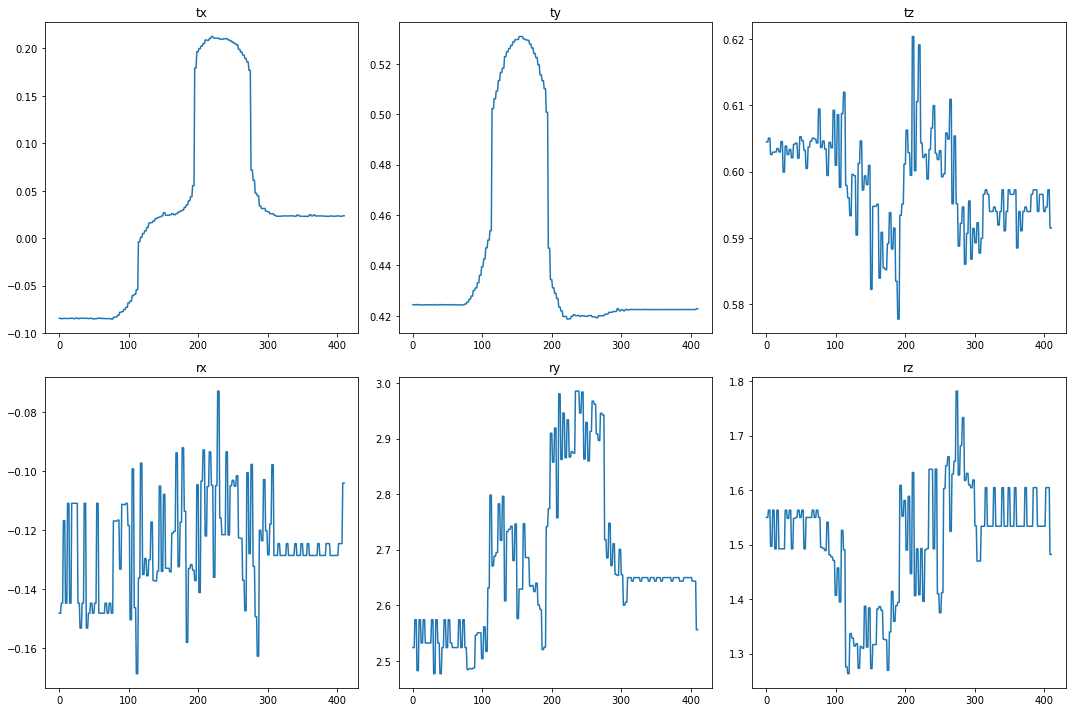

In [857]:
# Read the CSV file using pandas
data = pd.read_csv('transformed.csv')

# Extract the columns
tx = data['tx'].values
ty = data['ty'].values
tz = data['tz'].values
rx = data['rx'].values
ry = data['ry'].values
rz = data['rz'].values

# Plot the transformed data
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0, 0].plot(tx)
ax[0, 0].set_title('tx')

ax[0, 1].plot(ty)
ax[0, 1].set_title('ty')

ax[0, 2].plot(tz)
ax[0, 2].set_title('tz')

ax[1, 0].plot(rx)
ax[1, 0].set_title('rx')

ax[1, 1].plot(ry)
ax[1, 1].set_title('ry')

ax[1, 2].plot(rz)
ax[1, 2].set_title('rz')

plt.tight_layout()
plt.show()

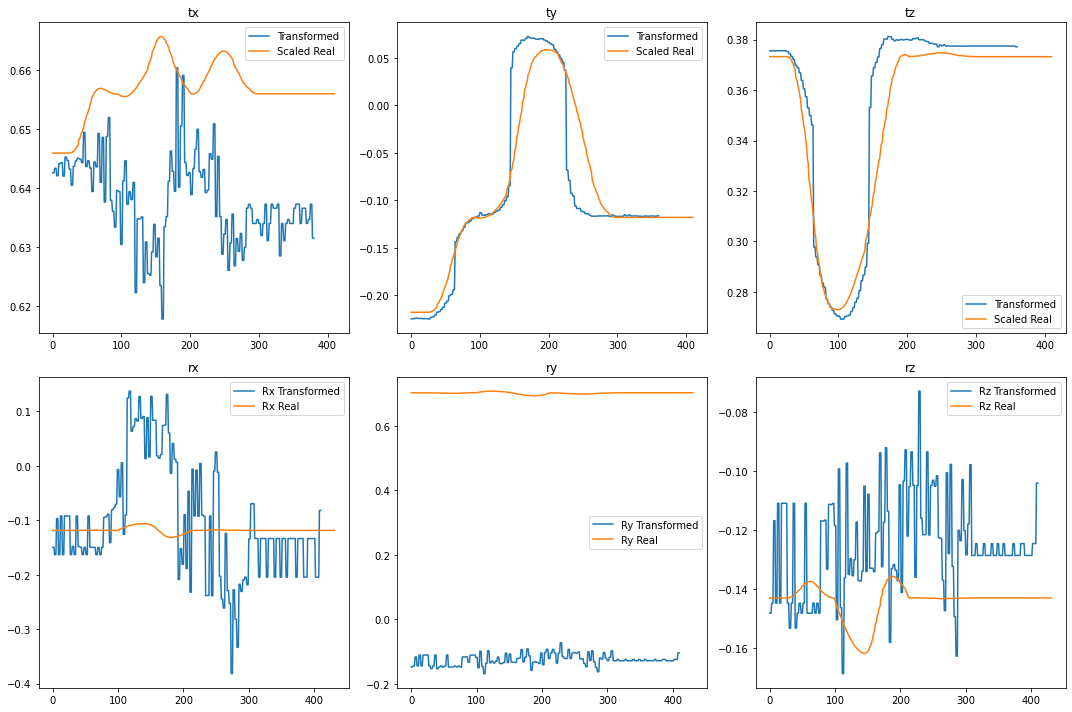

In [862]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

table_length = 0.75  # meters
marker_width = 0.068

# Read the transformed data from the CSV file
transformed_data = pd.read_csv('transformed.csv')

# Load data from the first file (real results)
real_results = np.loadtxt('iiwa_ee2.txt', usecols=(0, 1, 2, 3, 4, 5))

# Read the CSV file using pandas
data = pd.read_csv('nontransformed.csv')

# Extract translation data
real_tz = real_results[:, 2]
real_ty = real_results[:, 1]
real_tx = real_results[:, 0]

# Compute the scaling factor
scaling_factor = len(obtained_tz) / len(real_tz)

# Scale the larger dataset to match the length of the smaller dataset
scaled_real_tz = np.interp(np.arange(len(obtained_tz)), np.arange(len(real_tz)) * scaling_factor, real_tz)
scaled_real_ty = np.interp(np.arange(len(obtained_ty)), np.arange(len(real_ty)) * scaling_factor, real_ty)
scaled_real_tx = np.interp(np.arange(len(obtained_tx)), np.arange(len(real_tx)) * scaling_factor, real_tx)

# Make the obtained data the opposite
obtained_ty_opposite = obtained_ty + 0.024
# Make the obtained data the opposite
obtained_tz_opposite = -obtained_tz + 0.32
# Slice the obtained data from the 100th row onwards
obtained_tz_opposite = obtained_tz_opposite[50:]

# Extract the columns from the transformed data
tx_transformed = transformed_data['tz'].values
ty_transformed = transformed_data['tx'].values
tz_transformed = transformed_data['ty'].values
rx_transformed = transformed_data['rx'].values
ry_transformed = transformed_data['ry'].values
rz_transformed = transformed_data['rz'].values

# shifts
tx_transformed = tx_transformed[30:]
ty_transformed = ty_transformed[50:]
tz_transformed = tz_transformed[50:]

rx_transformed = rx_transformed[:]
ry_transformed = ry_transformed[:]
rz_transformed = rz_transformed[:]

# Plot the transformed data and scaled real results
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0, 0].plot(tx_transformed + 0.04, label='Transformed')
ax[0, 0].plot(scaled_real_tx, label='Scaled Real')
ax[0, 0].set_title('tx')
ax[0, 0].legend()

ax[0, 1].plot(ty_transformed - 0.14, label='Transformed')
ax[0, 1].plot(scaled_real_ty, label='Scaled Real')
ax[0, 1].set_title('ty')
ax[0, 1].legend()

ax[0, 2].plot(-tz_transformed + 0.8, label='Transformed')
ax[0, 2].plot(scaled_real_tz, label='Scaled Real')
ax[0, 2].set_title('tz')
ax[0, 2].legend()

ax[1, 0].plot(-rz_transformed + 1.4, label='Rx Transformed')
ax[1, 0].plot(scaled_real_rx, label='Rx Real')
ax[1, 0].set_title('rx')
ax[1, 0].legend()

ax[1, 1].plot(rx_transformed + 0, label='Ry Transformed')
ax[1, 1].plot(scaled_real_ry, label='Ry Real')
ax[1, 1].set_title('ry')
ax[1, 1].legend()

ax[1, 2].plot(rx_transformed - 0, label='Rz Transformed')
ax[1, 2].plot(scaled_real_rz, label='Rz Real')
ax[1, 2].set_title('rz')
ax[1, 2].legend()

plt.tight_layout()
plt.show()

In [509]:
intersection_data

,Time,tx,ty,tz,rx,ry,rz
0,0.079757,-0.054622,0.057409,0.676197,-0.058446,2.806954,0.393135
1,0.159514,-0.054622,0.057409,0.676197,-0.058446,2.806954,0.393135
2,0.239271,-0.054622,0.057409,0.676197,-0.058446,2.806954,0.393135
3,0.319028,-0.054837,0.058052,0.677095,-0.075022,2.880294,0.503766
4,0.398786,-0.054837,0.058052,0.677095,-0.075022,2.880294,0.503766
...,...,...,...,...,...,...,...
427,34.136047,0.051980,0.054409,0.666048,-0.001056,2.851101,0.331602
428,34.215804,0.051980,0.054409,0.666048,-0.001056,2.851101,0.331602
429,34.295561,0.051958,0.054369,0.671799,-0.041036,2.889870,0.324056
430,34.375318,0.051958,0.054369,0.671799,-0.041036,2.889870,0.324056
